## Import Libraries

In [25]:
import pandas as pd
import numpy as np
from scipy import linalg, optimize
import re
import random
import math
import string
from nltk.corpus import wordnet as wn
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from nltk import word_tokenize
from scipy import optimize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix, hstack, vstack
import seaborn as sns
import pickle
# Graphing: 
%matplotlib inline


## Reading in of Data

In [26]:
combined = '/Users/vickiyew/Desktop/bt4222_data/combined_psf.csv'

## Transform into DataFrame and Pre-processing

In [27]:
df = pd.read_csv(combined)
df.drop(df.columns[0], axis = 1, inplace=True)
df.head()

,district,street,propertyType,remaining_lease,school,hawkercentre,supermarkets,Bus Stops Nearby,crime_number,latitude,longitude,floor_range,sentiment,floor_area_sqft,price_psf
0,5,ZEHNDER ROAD,Semi-detached,999.00,27,6,8,0,-1.0,1.282130,103.786879,~-,0.380502,5643.51277,974.570312
1,5,ZEHNDER ROAD,Semi-detached,999.00,27,6,8,0,-1.0,1.282130,103.786879,~-,0.123495,3315.28120,1508.167693
2,5,ZEHNDER ROAD,Semi-detached,999.00,27,6,8,0,-1.0,1.282130,103.786879,~-,0.123495,3379.86460,1405.381742
3,5,NEO PEE TECK LANE,Terrace,999.00,27,6,8,2,-1.0,1.292047,103.768591,~-,0.380502,1714.68927,1533.805597
4,4,COVE DRIVE,Condominium,85.25,11,3,2,0,-1.0,1.244209,103.827487,~01-05,0.173732,2088.19660,1522.845119


In [28]:
# df['floor_area_sqft'] = 10.7639 * df['floor_area_sqm']
# df['price_psf'] = df['price'] / df['floor_area_sqft']
# cols = ['floor_area_sqm', 'price']
# df.drop(cols, axis = 1, inplace = True)
# df.head()

In [29]:
# df.to_csv('combined_psf.csv')

> Preprocessing

In [30]:
df['street'] = df['street'].astype('category')
street_dict = dict(zip(df['street'].cat.codes, df['street']))
df['street'] = df['street'].cat.codes

df['propertyType'] = df['propertyType'].astype('category')
property_dict = dict(zip(df['propertyType'].cat.codes, df['propertyType']))
df['propertyType'] = df['propertyType'].cat.codes

df['floor_range'] = df['floor_range'].astype('category')
floor_dict = dict(zip(df['floor_range'].cat.codes, df['floor_range']))
df['floor_range'] = df['floor_range'].cat.codes

## Train-test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('price_psf', axis=1),
                                                    df['price_psf'], 
                                                    test_size=0.2,
                                                    random_state=1)

## Feature Cross - Latitude & Longitude

In [32]:
_, longitude_boundaries = np.histogram(X_train['longitude'])
_, latitude_boundaries = np.histogram(X_train['latitude'])

def assign_bucket(x, ranges):
    if x <= ranges[0]:
        return 0
    
    for i in range(1, len(ranges) - 1):
        if x <= ranges[i]:
            return i - 1
    return len(ranges) - 2

X_train['lgt_discrete'] = X_train['longitude'].apply(lambda x: assign_bucket(x, longitude_boundaries))
X_train['lat_discrete'] = X_train['latitude'].apply(lambda x: assign_bucket(x, latitude_boundaries))
X_test['lgt_discrete'] = X_test['longitude'].apply(lambda x: assign_bucket(x, longitude_boundaries))
X_test['lat_discrete'] = X_test['latitude'].apply(lambda x: assign_bucket(x, latitude_boundaries))

In [33]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories='auto')
features_lat_lgn_train = enc.fit_transform(X_train[['lgt_discrete', 'lat_discrete']]) # fit and transform TRAIN
features_lat_lgn_test = enc.transform(X_test[['lgt_discrete', 'lat_discrete']]) # transform only TEST

In [34]:
features_to_drop = ['longitude', 'latitude', 'lgt_discrete', 'lat_discrete']
OHE_train = np.hstack((X_train.drop(features_to_drop, axis=1).values, features_lat_lgn_train.toarray()))
OHE_test = np.hstack((X_test.drop(features_to_drop, axis=1).values, features_lat_lgn_test.toarray()))

## XGBoost Modelling & RandomisedSearchCV

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV


# Initialise XGBRegressor
rf = XGBRegressor(n_estimators=300, subsample=0.9, colsample_bytree=0.2, eval_metric = 'rmse')


# # Set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)


# Pipeline Standardization and Model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# Tuning the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]
my_subsample = [0.7, 0.8, 0.9]
my_colsample_bytree = [0.1, 0.2, 0.3]

# Run the model using GridSearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = RandomizedSearchCV(estimator=pipeline
                            , cv=cv
                            , param_distributions =dict(model__min_samples_leaf = my_min_samples_leaf, 
                                               model__max_depth = my_max_depth,
                                               model__subsample = my_subsample,
                                               model__colsample_bytree = my_colsample_bytree)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )

# Fitting on Training Data
optimized_rf.fit(OHE_train, y_train)


# Best model estimators
print(optimized_rf.best_estimator_)

def adjusted_r2(r2, n, p):
  result = 1-((1-r2)*((n-1)/(n-p-1)))
  return result


# Evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = optimized_rf.predict(OHE_train)
y_pred = optimized_rf.predict(OHE_test)
n1 = len(y_train_pred)
p1 = X_train.shape[1]
n2 = len(y_pred)
p2 = X_test.shape[1]
print('Training Errors')
print("Mean Squared Error: ", mean_squared_error(y_train, y_train_pred))
print("RMSE: ", mean_squared_error(y_train, y_train_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(y_train, y_train_pred))
print("R-squared: ", r2_score(y_train, y_train_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(y_train, y_train_pred), n1, p1))

print('Test Errors')
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("R-squared: ", r2_score(y_test, y_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(y_test, y_pred), n2, p2))


def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred.squeeze()-y_true.squeeze()) / (np.abs(y_true.squeeze()) + np.abs(y_pred.squeeze()))*100)


print('Training sMAPE')
print(smape(y_train_pred, y_train))
print('Testing sMAPE')
print(smape(y_pred, y_test))

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

print('Training MAPE')
print(mape(y_train_pred, y_train))
print('Testing MAPE')
print(mape(y_pred, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[20:35:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Pipeline(steps=[('standardize', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.2, eval_metric='rmse', gamma=0,
                              gpu_id=-1, importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=10, min_child_weight=1,
                  

> Save Model

In [67]:
# filename = 'saved_model.sav'
# pickle.dump(optimized_rf, open(filename, 'wb'))

In [36]:
len(OHE_train[0])

32

## Model Interpretability - SHAP

In [54]:
cols = ['floor_area_sqft', 'street', 'propertyType', 'remaining_lease', 'school', 'hawkercentre', 'supermarkets', 'Bus Stops Nearby', 'crime_number', 'floor_range', 'sentiment', 'district']
cols += [str(i) for i in range(0, 20)]
len(cols)

32

In [55]:
model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.2, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, min_samples_leaf=2, missing=None,
             monotone_constraints='()', n_estimators=300, n_fold=5, n_jobs=1,
             nthread=1, num_parallel_tree=1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=0, silent=None, subsample=0.9, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [56]:
df_train = pd.DataFrame(OHE_train, columns = cols)
model.fit(df_train, y_train)

[21:16:30] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:16:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { min_samples_leaf, n_fold } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.2, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, min_samples_leaf=2, missing=None,
             monotone_constraints='()', n_estimators=300, n_fold=5, n_jobs=1,
             nthread=1, num_parallel_tree=1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=0, silent=None, subsample=0.9, ...)

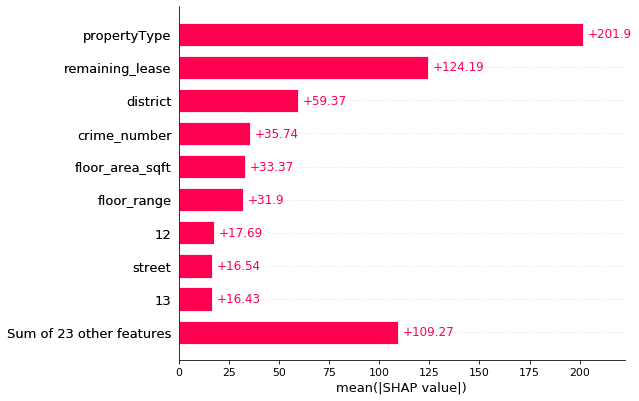

In [57]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(df_test)
shap.plots.bar(shap_values)

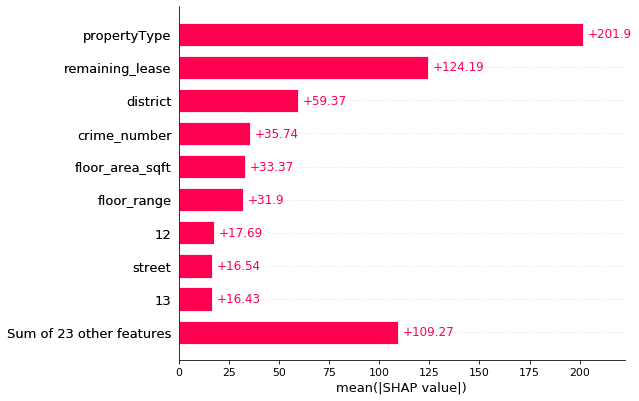

In [49]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(df_test)
shap.plots.bar(shap_values)

## LightGBM

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error
import xgboost
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV


# Initialise LGBMRegressor
rf = LGBMRegressor(n_estimators=300, subsample=0.9, colsample_bytree=0.2, eval_metric = 'rmse')


# # Set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)


# Pipeline Standardization and Model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# Tuning the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]
my_subsample = [0.7, 0.8, 0.9]
my_colsample_bytree = [0.1, 0.2, 0.3]

# Run the model using GridSearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = RandomizedSearchCV(estimator=pipeline
                            , cv=cv
                            , param_distributions =dict(model__min_samples_leaf = my_min_samples_leaf, 
                                               model__max_depth = my_max_depth,
                                               model__subsample = my_subsample,
                                               model__colsample_bytree = my_colsample_bytree)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )

# Fitting on Training Data
optimized_rf.fit(OHE_train, y_train)


# Best model estimators
print(optimized_rf.best_estimator_)

def adjusted_r2(r2, n, p):
  result = 1-((1-r2)*((n-1)/(n-p-1)))
  return result


# Evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = optimized_rf.predict(OHE_train)
y_pred = optimized_rf.predict(OHE_test)
n1 = len(y_train_pred)
p1 = X_train.shape[1]
n2 = len(y_pred)
p2 = X_test.shape[1]
print('Training Errors')
print("Mean Squared Error: ", mean_squared_error(y_train, y_train_pred))
print("RMSE: ", mean_squared_error(y_train, y_train_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(y_train, y_train_pred))
print("R-squared: ", r2_score(y_train, y_train_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(y_train, y_train_pred), n1, p1))

print('Test Errors')
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, squared = False))
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("R-squared: ", r2_score(y_test, y_pred))
print("Adjusted R2: ", adjusted_r2(r2_score(y_test, y_pred), n2, p2))


def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred.squeeze()-y_true.squeeze()) / (np.abs(y_true.squeeze()) + np.abs(y_pred.squeeze()))*100)


print('Training sMAPE')
print(smape(y_train_pred, y_train))
print('Testing sMAPE')
print(smape(y_pred, y_test))

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

print('Training MAPE')
print(mape(y_train_pred, y_train))
print('Testing MAPE')
print(mape(y_pred, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Pipeline(steps=[('standardize', StandardScaler()),
                ('model',
                 LGBMRegressor(colsample_bytree=0.3, eval_metric='rmse',
                               max_depth=12, min_samples_leaf=25,
                               n_estimators=300, subsample=0.7))])
Training Errors
Mean Squared Error:  9420.84414631337
RMSE:  97.0610330993513
Mean Absolute Error:  54.3883166726664
R-squared:  0.9632034061588841
Adjusted R2:  0.9631979005199309
Test Errors
Mean Squared Error:  11254.50968282832
RMSE:  106.08727389667584
Mean Absolute Error:  57.44930968181258
R-squared:  0.9566775299183612
Adjusted R2:  0.9566515892903418
Training sMAPE
7.349356363721403
Testing sMAPE
7.575082